In [594]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting

In [723]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")


## PLS ANALYSIS

In [803]:
all_volumes_file = 'data/all_volumes.csv'
all_volumes = pd.read_csv(all_volumes_file)

In [800]:
columns = list(range(0,3)) + list(range(21,54)) + list(range(61,467))
selected_values = all_volumes.iloc[:,columns]

## NORMALIZATION BY ETIV

In [801]:
selected_values.iloc[:,4:] = selected_values.iloc[:,4:].div(selected_values["Estimated Total Intracranial Volume"], axis=0)


In [802]:
all_data = selected_values
all_data.shape

(124, 442)

## Clinical data

In [35]:
clinical_file = 'data/clinical_data_prisma_VF.csv'
clinical_data = pd.read_csv(clinical_file)
clinical_data = clinical_data.iloc[:, [9,0,2,3,4,5,6,7,8,15]]
clinical_data.rename(columns = {'id_RM':'subject'}, inplace = True)

## Edit file

In [36]:
pd.set_option('display.max_rows', None)

#add same treatment in all times
l=["Group",'time','edad','gen','esc','dx','psc', 'Gravedad'] # column different from each row
clinical_data_f = pd.concat([clinical_data.drop(l,1).groupby('subject').transform('first'),clinical_data[l],clinical_data[['subject']]],axis=1).reindex(columns=clinical_data.columns)

clinical_data_f['project'] = 'prisma'+ clinical_data_f.time.astype(str)

clinical_data_f.loc[clinical_data_f.Group == 'CTR', 'project'] = "controles"
clinical_data_f['c_group'] = clinical_data_f['Group'] + '-' + clinical_data_f['project'] +'-' +'treatment' + clinical_data_f['treatment'].astype(str)

## Merge both files

In [50]:
clinical_image_df= pd.merge(all_data, clinical_data_f[['subject','project','c_group','treatment','psc','dx','Gravedad']], how='left', on=['subject', 'project'])

#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[(clinical_image_df.subject.str.contains('TAB'))&(clinical_image_df.dx==2)],inplace=True)

# Remove subject with NAs in volumes
clinical_image_df.drop(clinical_image_df.index[clinical_image_df.subject=="TABP079"],inplace=True)


### NORMALIZE BY GROUP

## Standardscaler

In [57]:
clinical_image_df_n_CTR= clinical_image_df[clinical_image_df.grupo=='CTR']
clinical_image_df_n_EQF= clinical_image_df[clinical_image_df.grupo=='EQF']
clinical_image_df_n_TAB= clinical_image_df[clinical_image_df.grupo=='TAB']
clinical_image_df_n_CTR.iloc[:,4:-5] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_CTR.iloc[:,4:-5])
clinical_image_df_n_TAB.iloc[:,4:-5] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_TAB.iloc[:,4:-5])
clinical_image_df_n_EQF.iloc[:,4:-5] = preprocessing.StandardScaler().fit_transform(clinical_image_df_n_EQF.iloc[:,4:-5])


/Users/pyxis/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/Users/pyxis/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/Users/pyxis/opt/anaconda3/envs/hmm/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/pyxis/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: F

## Z-score by subject

In [318]:
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,4:-5] = clinical_image_z.iloc[:,4:-5].apply(zscore, axis=1)

In [62]:
clinical_image_n = pd.concat([clinical_image_df_n_CTR,clinical_image_df_n_TAB,clinical_image_df_n_EQF])

In [319]:
clinical_image_i = clinical_image_z
clinical_image_EQF = clinical_image_i[clinical_image_i.grupo!='TAB']
clinical_image_TAB = clinical_image_i[clinical_image_i.grupo!='EQF']

In [320]:
all_data_sorted_EQF = clinical_image_EQF.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_EQF = all_data_sorted_EQF.groupby(['c_group']).count()
groups_dict_EQF = count_groups_EQF['subject'].to_dict()

list_len_EQF = list(groups_dict_EQF.values())
groups_EQF = list(groups_dict_EQF.keys())
groups_dict_EQF

{'CTR-controles-treatment0.0': 16,
 'EQZ-prisma1-treatment1.0': 11,
 'EQZ-prisma1-treatment2.0': 6,
 'EQZ-prisma3-treatment1.0': 10,
 'EQZ-prisma3-treatment2.0': 7}

In [321]:
all_data_sorted_TAB = clinical_image_TAB.sort_values('c_group', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups_TAB = all_data_sorted_TAB.groupby(['c_group']).count()
groups_dict_TAB = count_groups_TAB['subject'].to_dict()

list_len_TAB = list(groups_dict_TAB.values())
groups_TAB = list(groups_dict_TAB.keys())
groups_dict_TAB

{'CTR-controles-treatment0.0': 16,
 'TAB-prisma1-treatment1.0': 17,
 'TAB-prisma1-treatment2.0': 16,
 'TAB-prisma3-treatment1.0': 20,
 'TAB-prisma3-treatment2.0': 17}

## PLS WITH CLINICAL GROUPS

In [322]:
X_EQF = all_data_sorted_EQF.iloc[:,4:-5].values
X_TAB = all_data_sorted_TAB.iloc[:,4:-5].values


In [325]:
random_state=42
pls_EQF = pyls.meancentered_pls(X_EQF, groups=list_len_EQF, seed=42, mean_centering=1, n_proc='max')



Making permutations:   0%|          | 0/5000 | 00:00<?

Making permutations:   4%|4         | 213/5000 | 00:00<00:02

Making permutations:   9%|8         | 439/5000 | 00:00<00:02

Making permutations:  14%|#3        | 682/5000 | 00:00<00:01

Making permutations:  19%|#8        | 937/5000 | 00:00<00:01

Making permutations:  24%|##3       | 1178/5000 | 00:00<00:01

Making permutations:  28%|##8       | 1418/5000 | 00:00<00:01

Making permutations:  33%|###3      | 1657/5000 | 00:00<00:01

Making permutations:  38%|###7      | 1896/5000 | 00:00<00:01

Making permutations:  43%|####2     | 2128/5000 | 00:00<00:01

Making permutations:  47%|####7     | 2353/5000 | 00:01<00:01

Making permutations:  52%|#####1    | 2575/5000 | 00:01<00:01

Making permutations:  56%|#####5    | 2795/5000 | 00:01<00:01

Running permutations:   0%|          | 16/5000 | 00:13<10:410

Making permutations:  64%|######4   | 3213/5000 | 00:01<00:00

Making permutations:  68%|######8   | 3415/5000 | 00:01<00:00

M

In [763]:
with open('pls_V_EQF_n.pkl', 'wb') as f:
    pickle.dump(pls_EQF, f)

In [ ]:
with open("pls_EQF.pkl", "rb") as input_file:
    pls_EQF = pickle.load(input_file)

In [326]:
pls_TAB = pyls.meancentered_pls(X_TAB, groups=list_len_TAB, mean_centering=1, seed=42, n_proc='max')


In [764]:
with open('pls_V_TAB_n.pkl', 'wb') as f:
    pickle.dump(pls_TAB, f)

In [ ]:
with open("pls_TAB.pkl", "rb") as input_file:
    pls_TAB = pickle.load(input_file)

In [327]:
pvals_EQF = pls_EQF.permres['pvals']
x_weights_EQF = pls_EQF.bootres.x_weights_normed
y_weights_EQF = pls_EQF.y_weights
pvals_EQF

array([5.99880024e-04, 2.60147970e-01, 1.00000000e+00, 1.00000000e+00,
       9.69406119e-01])

In [328]:
pvals_TAB = pls_TAB.permres['pvals']
x_weights_TAB = pls_TAB.bootres.x_weights_normed
y_weights_TAB = pls_TAB.y_weights
pvals_TAB

array([5.99880024e-04, 1.04579084e-01, 1.00000000e+00, 1.00000000e+00,
       6.39472106e-01])

In [389]:
def get_pos(n_col, init=-0.3, inte=0.6):
    pos = []
    for i in range(n_col):
        x = init 
        init = round(x + inte, 1)
        pos.append(x)
    return pos

def errplot(x,y, yerr, **kwargs):
    data = kwargs.pop("data")
    plt.errorbar(x=x,y=data[y],yerr=data[yerr],fmt='none', c= 'k')

In [693]:
y_loadings_df_EQF = pd.DataFrame({'1': y_weights_EQF[:,0], '2': y_weights_EQF[:,1], 'condition': groups_EQF,
                                  'tratamiento': [group.split("-")[2] for group in groups_EQF] , 'time': [group.split("-")[1] for group in groups_EQF]})

y_loadings_m_EQF = pd.melt(y_loadings_df_EQF,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_EQF['ci_l'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,0], pls_EQF.bootres.contrast_ci[:,1,0]])
y_loadings_m_EQF['ci_u'] = np.concatenate([pls_EQF.bootres.contrast_ci[:,0,1], pls_EQF.bootres.contrast_ci[:,1,1]])

y_loadings_m_EQF['ci_l_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_l']
y_loadings_m_EQF['ci_u_p'] = y_loadings_m_EQF['weight'] - y_loadings_m_EQF['ci_u']
y_loadings_m_EQF['err'] = (y_loadings_m_EQF['ci_u'] - y_loadings_m_EQF['ci_l'])/2

In [726]:
y_loadings_df_TAB = pd.DataFrame({'1': y_weights_TAB[:,0], '2': y_weights_TAB[:,1], 'condition': groups_TAB,
                                 'tratamiento': [group.split("-")[2] for group in groups_TAB] , 'time': [group.split("-")[1] for group in groups_TAB]})
y_loadings_m_TAB = pd.melt(y_loadings_df_TAB,id_vars=['condition','tratamiento','time'],value_name='weight', var_name = 'salvar_id')

y_loadings_m_TAB['ci_l'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,0], pls_TAB.bootres.contrast_ci[:,1,0]])
y_loadings_m_TAB['ci_u'] = np.concatenate([pls_TAB.bootres.contrast_ci[:,0,1], pls_TAB.bootres.contrast_ci[:,1,1]])

y_loadings_m_TAB['ci_l_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_l']
y_loadings_m_TAB['ci_u_p'] = y_loadings_m_TAB['weight'] - y_loadings_m_TAB['ci_u']
y_loadings_m_TAB['err'] = (y_loadings_m_TAB['ci_u'] - y_loadings_m_TAB['ci_l'])/2

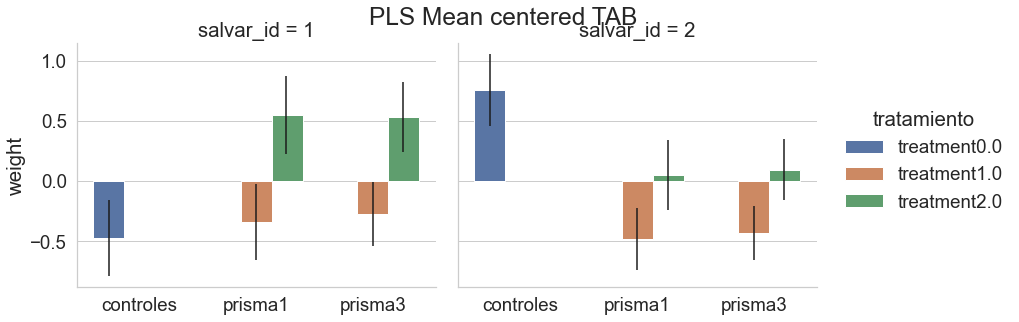

In [738]:
g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_TAB)

g.map_dataframe(errplot,  [-0.26,1,1.26,2,2.26], "weight", "err")
plt.suptitle('PLS Mean centered TAB')
g.set_xlabels('')


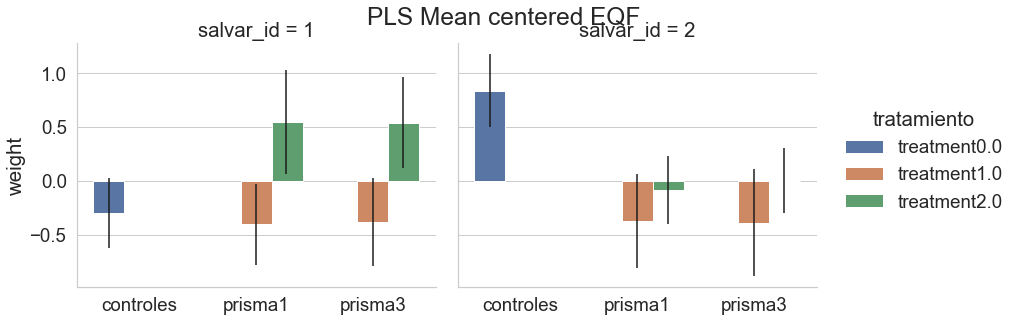

In [736]:
g = sns.catplot(x="time", y="weight", kind="bar", col="salvar_id", ci=None, aspect=1.2, hue="tratamiento",data=y_loadings_m_EQF)

g.map_dataframe(errplot, [-0.26,1,1.26,2,2.26], "weight", "err")

plt.suptitle('PLS Mean centered EQF')
g.set_xlabels('')


In [333]:
pls_EQF.permres.pvals

array([5.99880024e-04, 2.60147970e-01, 1.00000000e+00, 1.00000000e+00,
       9.69406119e-01])

In [667]:
pls_EQF.varexp

array([6.72344374e-01, 2.13073786e-01, 7.94142061e-02, 3.51676337e-02,
       6.01465365e-31])

In [334]:
pls_TAB.permres.pvals

array([5.99880024e-04, 1.04579084e-01, 1.00000000e+00, 1.00000000e+00,
       6.39472106e-01])

In [668]:
pls_TAB.varexp

array([5.46834673e-01, 3.52523116e-01, 6.53440661e-02, 3.52981444e-02,
       1.90406480e-30])

In [634]:
x_score_1_EQF=pls_EQF.x_scores
Y_score_1_EQF=pls_EQF.y_scores

score_EQF = pd.DataFrame()
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['grupo'] = all_data_sorted_EQF['grupo']
score_EQF['subject'] = all_data_sorted_EQF['subject']
score_EQF['project'] = all_data_sorted_EQF['project']
score_EQF['treatment'] = all_data_sorted_EQF['treatment']
score_EQF['psc'] = all_data_sorted_EQF['psc'].where(pd.notnull(all_data_sorted_EQF['psc']), -1).astype(int)
score_EQF['Gravedad'] = all_data_sorted_EQF['Gravedad']
score_EQF['x_score_1']=pls_EQF.x_scores[:,0]
score_EQF['y_score_1']=pls_EQF.y_scores[:,0]
score_EQF['x_score_2']=pls_EQF.x_scores[:,1]
score_EQF['y_score_2']=pls_EQF.y_scores[:,1]

score_TAB = pd.DataFrame()
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['grupo'] = all_data_sorted_TAB['grupo']
score_TAB['subject'] = all_data_sorted_TAB['subject']
score_TAB['project'] = all_data_sorted_TAB['project']
score_TAB['treatment'] = all_data_sorted_TAB['treatment']
score_TAB['psc'] = all_data_sorted_TAB['psc'].where(pd.notnull(all_data_sorted_TAB['psc']), -1).astype(int)
score_TAB['Gravedad'] = all_data_sorted_TAB['Gravedad']
score_TAB['x_score_1']=pls_TAB.x_scores[:,0]
score_TAB['y_score_1']=pls_TAB.y_scores[:,0]
score_TAB['x_score_2']=pls_TAB.x_scores[:,1]
score_TAB['y_score_2']=pls_TAB.y_scores[:,1]

In [771]:
#color = {0: 'w', 1: 'k', 100: 'r'}
color = {0: 'w', 1: 'k', -1: 'r'}
#color = {'controles':'w','prisma1': 'w','prisma3':'k'}

subject_n = pd.factorize(score_TAB.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_TAB['subject_color'] = le.fit_transform(subject_n)
score_TAB['edge_color'] = score_TAB.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)

lee = LabelEncoder()
subject_n = pd.factorize(score_EQF.apply(lambda x: 'CTRL' if 'CTRL' in x['subject'] else x['subject'], axis=1))[0]
score_EQF['subject_color'] = lee.fit_transform(subject_n)
score_EQF['edge_color'] = score_EQF.apply(lambda x: color[x['psc']], axis=1)
#score_TAB['line_width'] = score_TAB.apply(lambda x: line[x['psc']], axis=1)


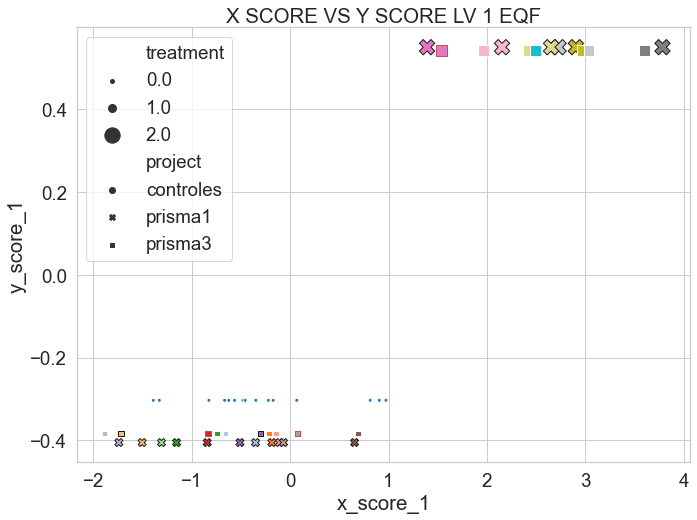

In [772]:
#sns.set(rc={'figure.figsize':(11,8)})
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 EQF")
plt.show()

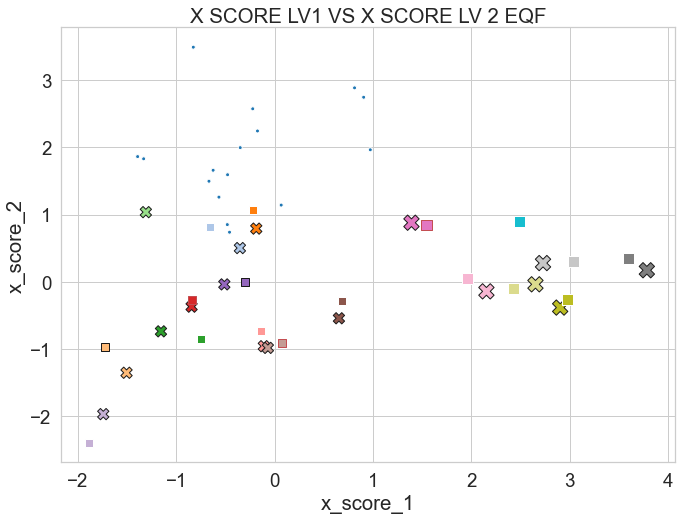

In [775]:
g=sns.scatterplot(x="x_score_1", y="x_score_2",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=False,
                palette='tab20',data=score_EQF,edgecolor=score_EQF["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV 2 EQF")
plt.show()

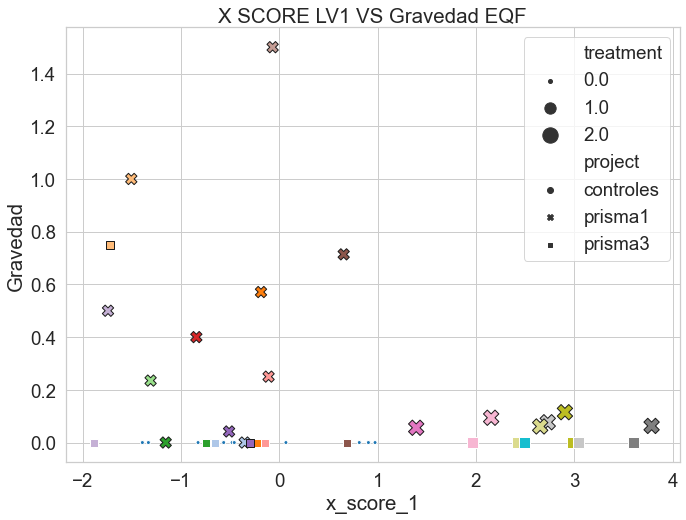

In [776]:
score_EQF_na = score_EQF.dropna(subset=['Gravedad'])
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_EQF_na,edgecolor=score_EQF_na["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[20:]
selected_labels = current_labels[20:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad EQF")
plt.show()

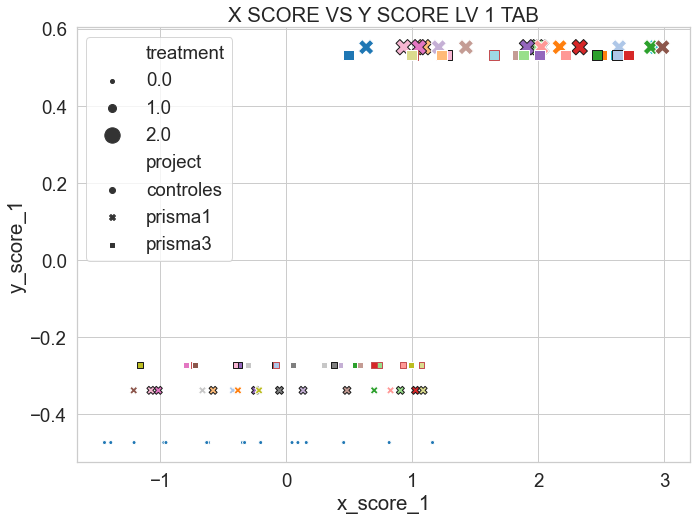

In [777]:
g=sns.scatterplot(x="x_score_1", y="y_score_1",
                 hue="subject_color", style="project", size='treatment',sizes=[16,64,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE VS Y SCORE LV 1 TAB")
plt.show()

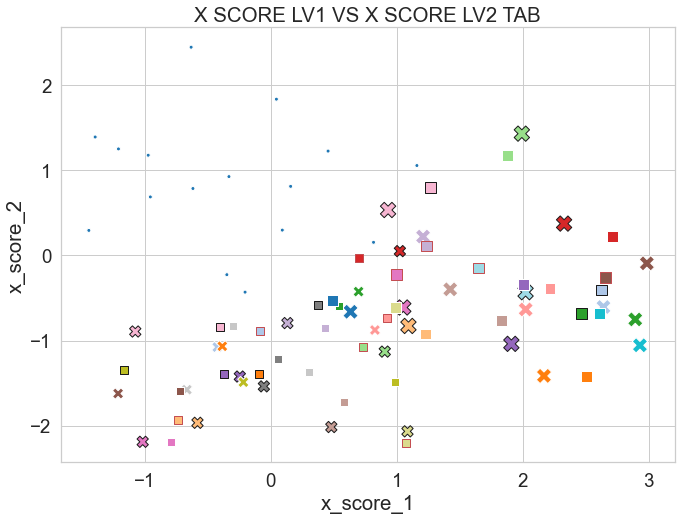

In [780]:
#sns.set(rc={'figure.figsize':(11,8)})
g= sns.scatterplot(x="x_score_1", y="x_score_2",
                hue="subject_color", style="project", size='treatment',sizes=[16,128,236],legend=False,
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)

current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
#plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS X SCORE LV2 TAB")
plt.show()


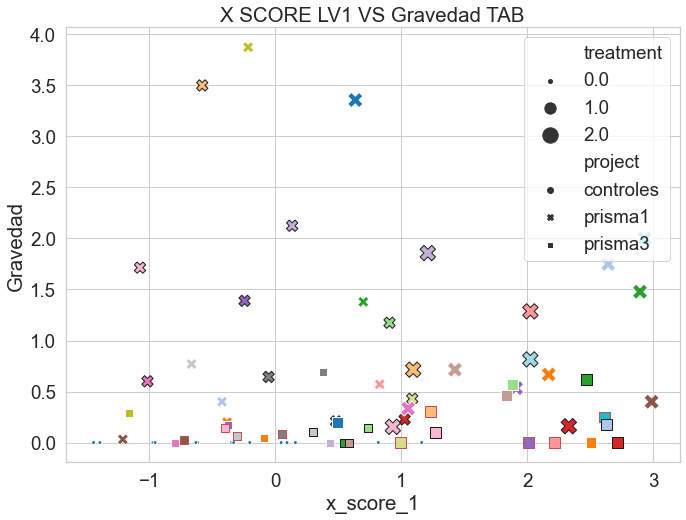

In [782]:
score_TAB_na = score_TAB.dropna(subset=['Gravedad'])
markers = {0.0: "X", 1.0: "o",2.0:"s"}
g=sns.scatterplot(x="x_score_1", y="Gravedad",
                 hue="subject_color", style="project", size='treatment',sizes=[16,128,236],
                palette='tab20',data=score_TAB,edgecolor=score_TAB["edge_color"],linewidth=1)
current_handles, current_labels = g.get_legend_handles_labels()
selected_handles = current_handles[39:]
selected_labels = current_labels[39:]
plt.legend(selected_handles,selected_labels)
plt.title("X SCORE LV1 VS Gravedad TAB")
plt.show()

## X Weights

In [746]:
yeo_pal = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'None': (0.7, 0.7, 0.7, 0.5)}

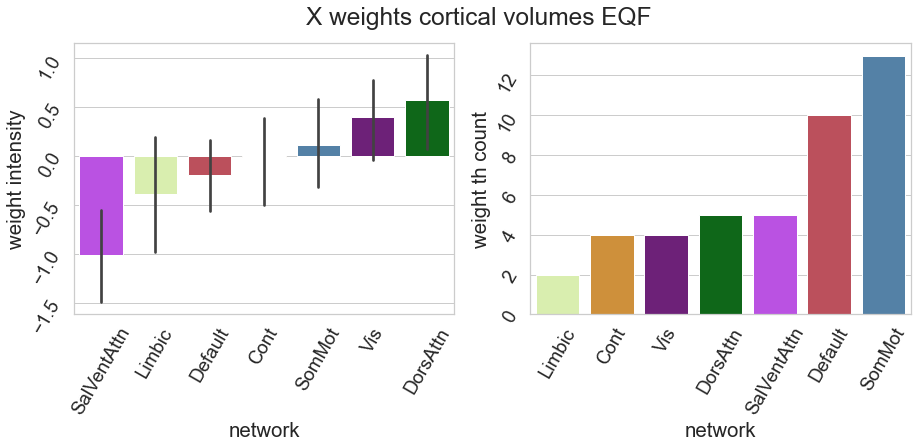

In [784]:
EQF_data = all_data_sorted_EQF.iloc[:,4:-5]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_7Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_EQF = pls_EQF.bootres.x_weights_normed[38:,0]
df_x_weights_sch_EQF = pd.DataFrame(sch_x_sch_weights_EQF, columns=["weight"])
df_x_weights_sch_EQF.index = networks7_order[1]
df_x_weights_sch_EQF["network"] = df_x_weights_EQF.index.str.split('_').str.get(2)
th = 3
df_x_weights_sch_EQF["weight_th"] =  (abs(df_x_weights_sch_EQF["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes EQF')

order_g = df_x_weights_sch_EQF.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0],palette=yeo_pal,order=order_g,
            data=df_x_weights_sch_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_EQF.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,palette=yeo_pal,order=order_h,
            data=df_x_weights_sch_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)


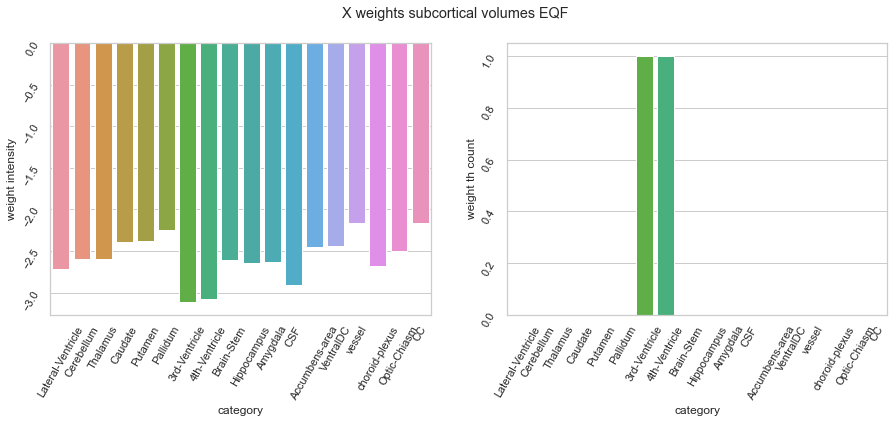

In [497]:
sch_x_v_weights_EQF = pls_EQF.bootres.x_weights_normed[:38,0]
df_x_weights_v_EQF = pd.DataFrame(sch_x_v_weights_EQF, columns=["weight"])
df_x_weights_v_EQF['volume'] = list(EQF_data.iloc[:,:38].columns)
df_x_weights_v_EQF['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_EQF["weight_th"] =  (abs(df_x_weights_v_EQF["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes EQF')

g=sns.barplot(x="category", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_EQF)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="category", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_EQF)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



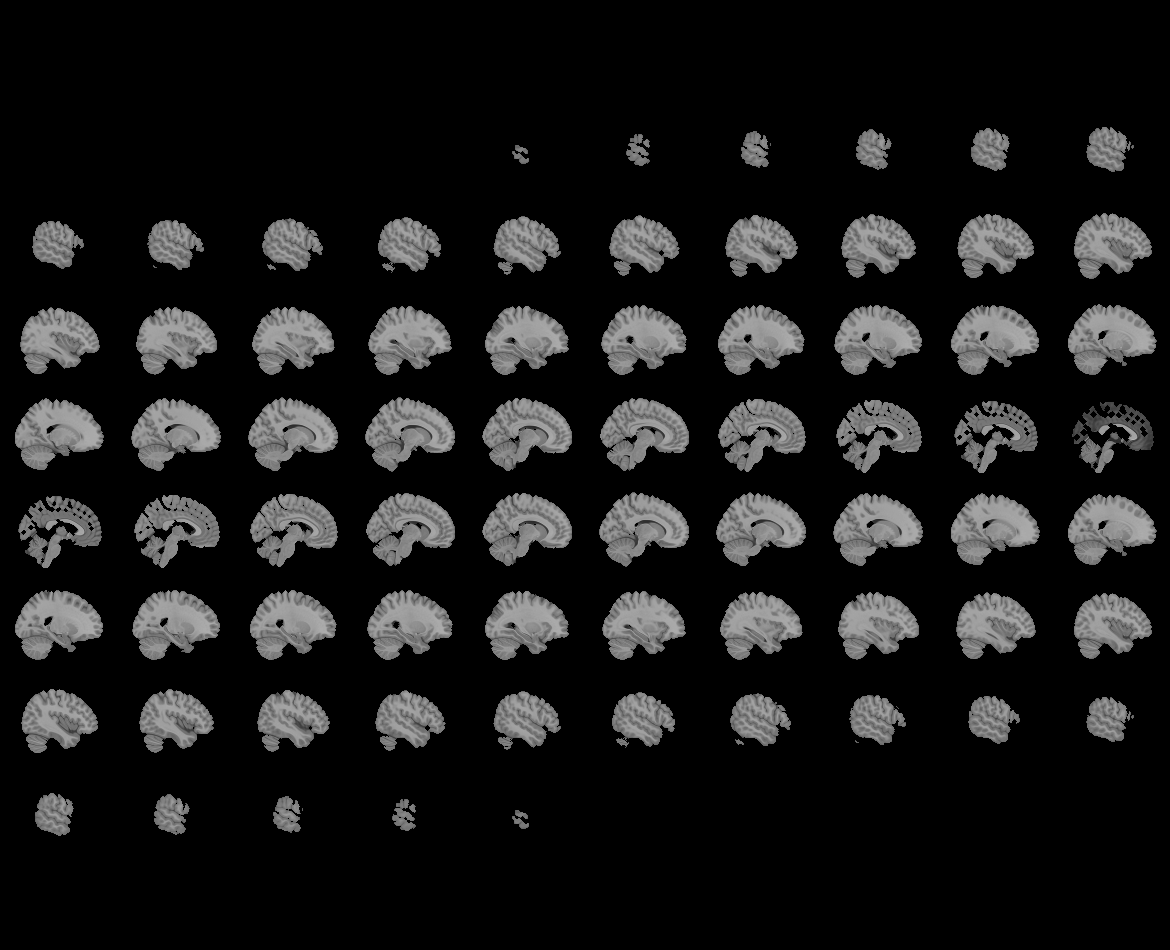
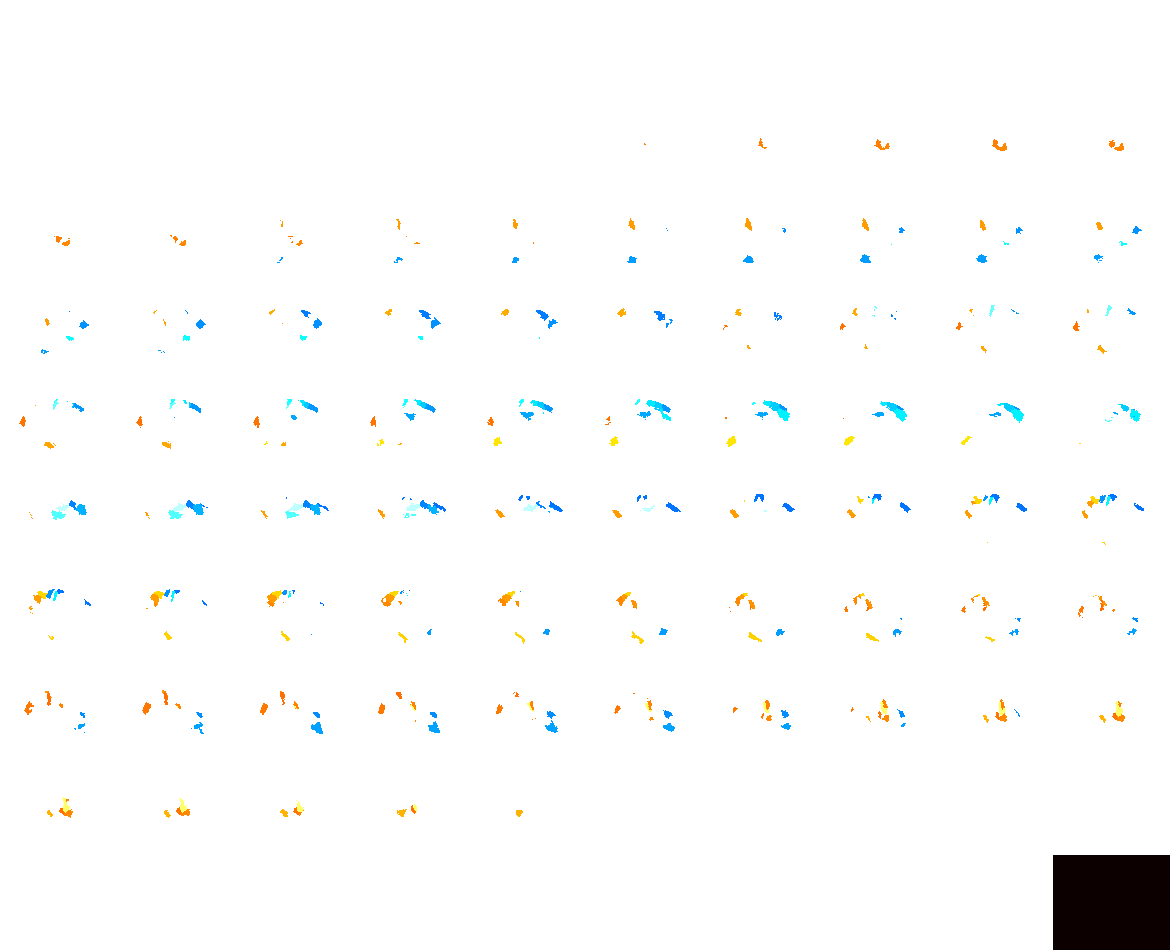

In [505]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = 3
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_EQF[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights EQF', symmetric_cmap=False)

## TAB

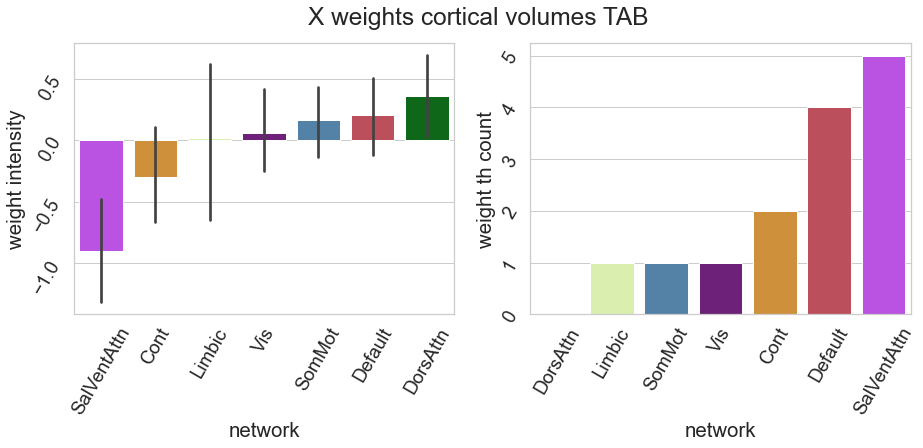

In [785]:
TAB_data = all_data_sorted_TAB.iloc[:,4:-5]
networks7_order = pd.read_csv('Schaefer2018_400Parcels_7Networks_order.txt',header=None,delimiter='\t')
sch_x_sch_weights_TAB = pls_TAB.bootres.x_weights_normed[38:,0]
df_x_weights_sch_TAB = pd.DataFrame(sch_x_sch_weights_TAB, columns=["weight"])
df_x_weights_sch_TAB.index = networks7_order[1]
df_x_weights_sch_TAB["network"] = df_x_weights_sch_TAB.index.str.split('_').str.get(2)
th = 3
df_x_weights_sch_TAB["weight_th"] =  (abs(df_x_weights_sch_TAB["weight"])>= th)*1


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights cortical volumes TAB')

order_g = df_x_weights_sch_TAB.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch_TAB.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_pal,
            data=df_x_weights_sch_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

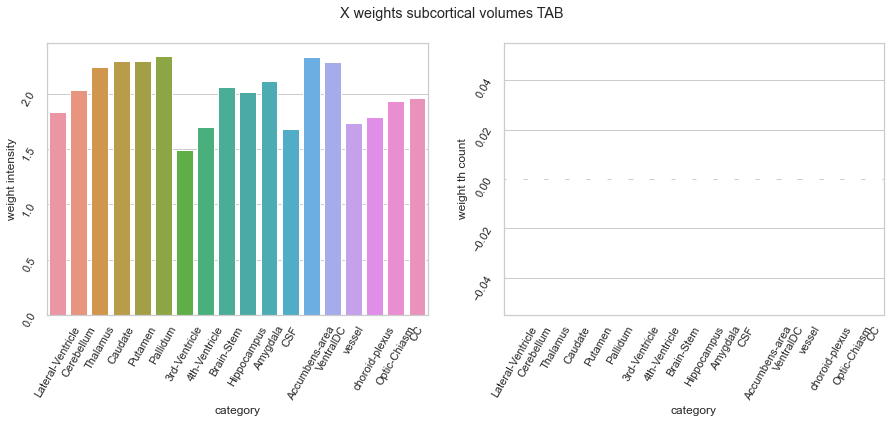

In [503]:
sch_x_v_weights_TAB = pls_TAB.bootres.x_weights_normed[:38,0]
df_x_weights_v_TAB = pd.DataFrame(sch_x_v_weights_TAB, columns=["weight"])
df_x_weights_v_TAB['volume'] = list(TAB_data.iloc[:,:38].columns)
df_x_weights_v_TAB['category'] = ['Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','3rd-Ventricle','4th-Ventricle','Brain-Stem','Hippocampus','Amygdala','CSF','Accumbens-area','VentralDC','vessel','choroid-plexus','Lateral-Ventricle','Lateral-Ventricle','Cerebellum','Cerebellum','Thalamus','Caudate','Putamen','Pallidum','Hippocampus','Amygdala','Accumbens-area','VentralDC','vessel','choroid-plexus','Optic-Chiasm','CC','CC','CC','CC','CC']
th = 3
df_x_weights_v_TAB["weight_th"] =  (abs(df_x_weights_v_TAB["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
fig.suptitle('X weights subcortical volumes TAB')

g=sns.barplot(x="category", y="weight", ci=None, ax=axes[0],
            data=df_x_weights_v_TAB)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
h = sns.barplot(x="category", y="weight_th", ci=None, ax=axes[1], estimator=sum,
            data=df_x_weights_v_TAB)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)

/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/Users/pyxis/.local/lib/python3.7/site-packages/nilearn/plotting/html_document.py:61: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



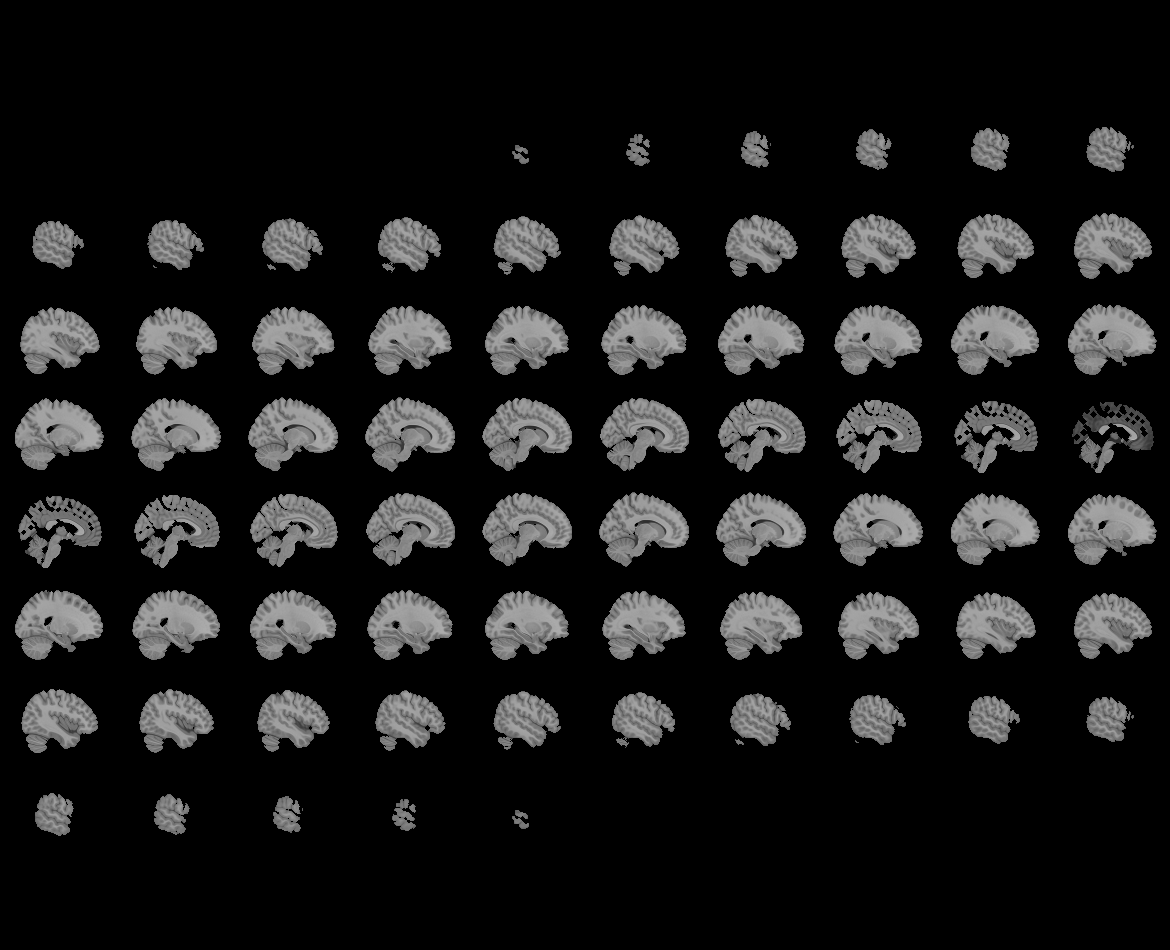
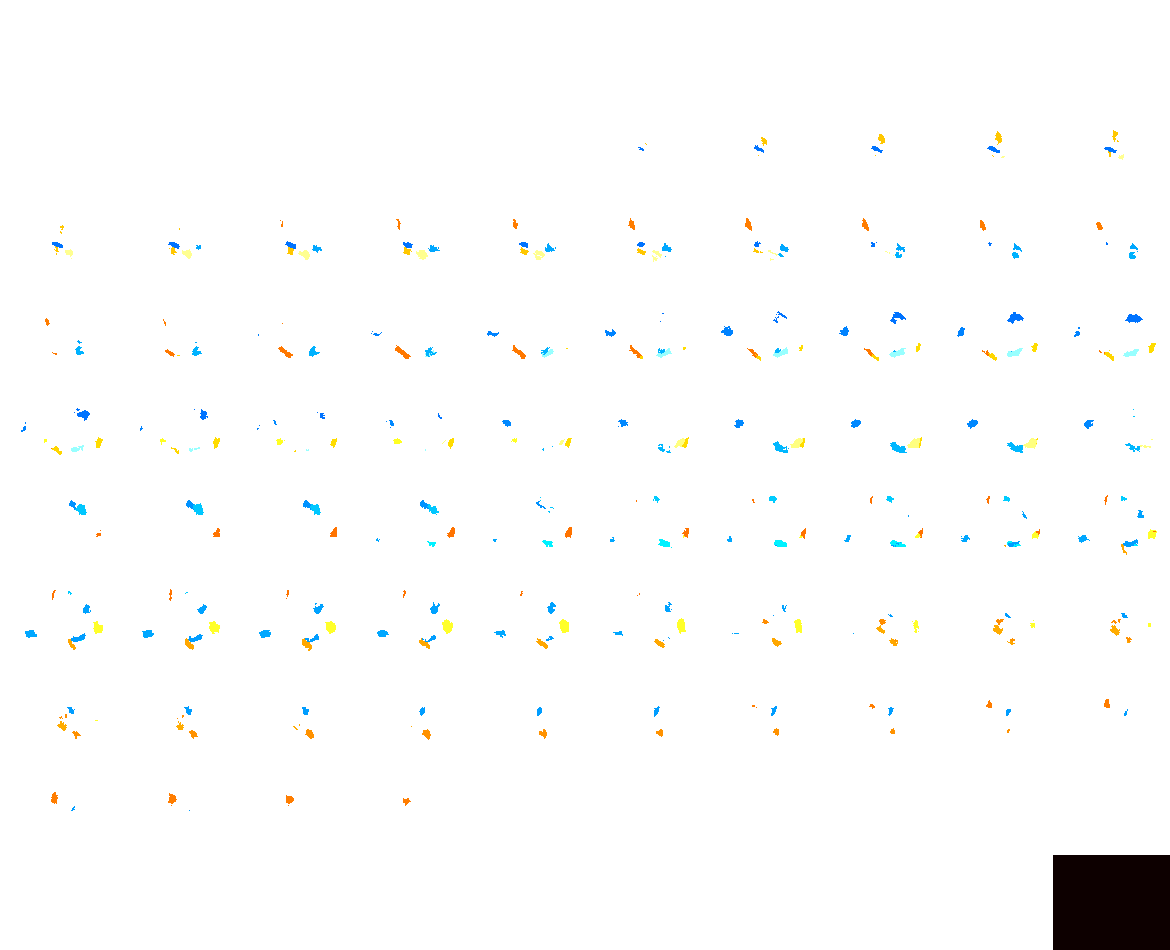

In [504]:
schaefer_image = 'Schaefer2018_400_17N_MNI152_2mm.nii'
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th = max(sch_x_sch_weights_TAB)*0.6
values_brain_weight_vol = sch_masker.inverse_transform(sch_x_sch_weights_TAB[np.newaxis,:])
plotting.view_img(values_brain_weight_vol, threshold=th, title='X weights TAB', symmetric_cmap=False)